# 视觉皮层构架 The Architecture of the Visual Cortex

# 卷积层 Convolutional Layers

几个用来绘制灰度和 RGB 图像的函数

In [1]:
def plot_image(image):
    # "nearest" 分辨率不匹配时,只显示图像而不尝试在像素之间进行插值
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")


def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## TensorFlow实现

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from functools import partial

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

In [3]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

在`TensorFlow`中:
- 每个输入图像通常表示的形状为$[height,width,channels]$的3D张量
- 小批量表示为形状$[mini\ batch\ size,height,width,channels]$的4D张量
- 卷积层的权重可以表示为$[f_h,f_w,f_{n^{'}},f_n]$的4D张量
    - $f_h,f_w$表示接受野的高度和宽度
    - $f_{n^{'}},f_n$表示上一层中特征图个数和这一层中特征图个数
- 卷积层的偏置项简单表示为形状$[f_n]$的一维张量.

示例:加载两个样本图像,然后创建两个滤波器并将其应用于两个图像中,最后显示其中一个的结果特征图.

In [4]:
from sklearn.datasets import load_sample_image

1. 加载图像 

In [5]:
# 缩放像素强度到0~1的浮点数
china = load_sample_image("china.jpg") / 255     # shape:(427, 640, 3)
flower = load_sample_image("flower.jpg") / 255   # shape:(427, 640, 3)

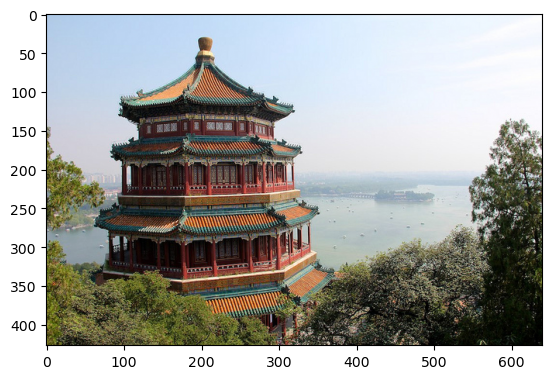

In [6]:
plt.imshow(china)
plt.show()

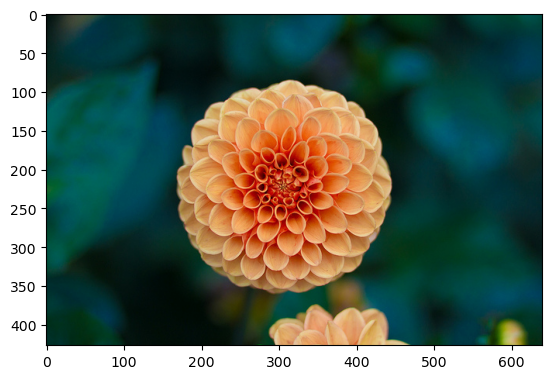

In [7]:
plt.imshow(flower)
plt.show()

In [8]:
# 将两幅图和成一个四维张量，表示有2个批次
images = np.array([china, flower])  # shape:(2, 427, 640, 3)
batch_size, height, width, channels = images.shape

2. 创建两个7*7的过滤器

In [9]:
# f_h=7(height), f_w=7(width)
# f_n′=channels=3   f_n=filters=2
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

In [10]:
filters[:, 3, :, 0] = 1  # 中间有垂直白线
filters[3, :, :, 1] = 1  # 中间有水平白线

<img src="../images/other/14-1.png" width="300">

3. 使用`tf.nn.conv2d()`应用于两个图像.

In [11]:
# 使用0填充("SAME")和步长为1
outputs = tf.nn.conv2d(input=images,
                       filters=filters,
                       strides=1,
                       padding="SAME")

2022-10-26 10:47:38.009399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:47:38.031464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:47:38.031606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 10:47:38.032381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

> `tf.nn.conv2d()`参数详解
1. `images`是输入的小批量
2. `filter`是要应用的一组滤波器
3. `strides`等于1,但也可以是包含四个元素的一维度组,其中两个中间元素是垂直步幅和水平步幅($s_h$和$s_w$)。第一个元素和最后一个元素必须等于1。格式为:`[1,stride,stride,1]`.它们可能会用于指定`批处理步幅`(跳过某些实例)和`通道步幅`(跳过某些上一层的特征图或通道)
4. `padding`必须为`SAME`或`VALID`,
    - 如果设置为`SAME`,则卷积层在必要时使用**零填充**。将输出大小设置为**输入神经元的数量除以步幅(向上取整)所得的值**。例如,如果输入大小为13而步幅为5,则输出大小为3,然后根据需要在输入周围尽可能均匀地添加零。**当 `strides=1`时,层的输出将具有与其输入相同的空间尺寸(宽度和高度)**,因此命名为`SAME`.
        - `等宽卷积`:步长$S=1$,两端补零$P=\frac{K-1}{2}$,卷积输出长度为$M$
    - 如果设置为`VALID`,则卷积层将**不使用零填充**,并且可能会忽路输入图像底部和右侧的某些行和列,具体取决于步幅,这意味着每个神经元的接受野都严格位于输入内部的有效位置内(不会超出范围),因此命名为`VALID`.
        - `窄卷积`:步长$S=1$,$P=0$,卷积输出长度为$M-K+1$

4. 绘制整体结果特征图

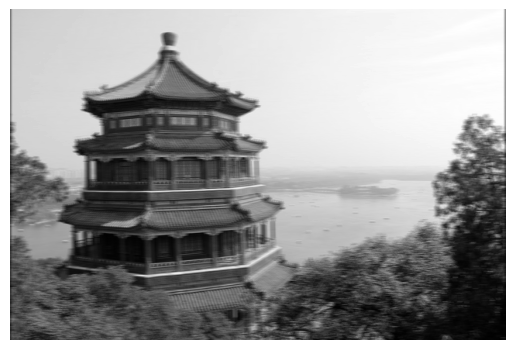

In [12]:
# 绘制第一张china图像的第二个特征图
plt.imshow(outputs[0, :, :, 1], cmap="gray")  # outputs_shape: [2,427,640,2]
plt.axis("off")
plt.show()

<img src="../images/other/14-3.png" width="500">

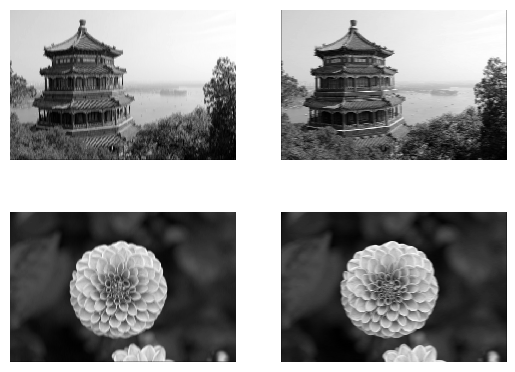

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

5. 观察局部特征

In [14]:
def crop(images):
    return images[150:220, 130:250]

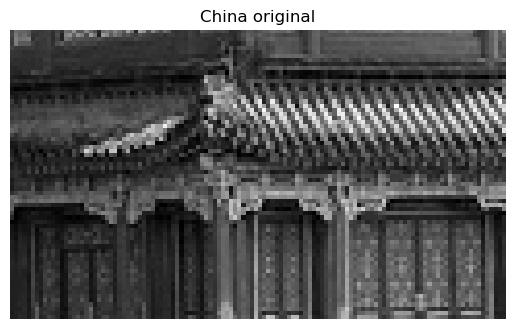

In [15]:
plot_image(crop(images[0, :, :, 0]))
plt.title("China original")
plt.show()

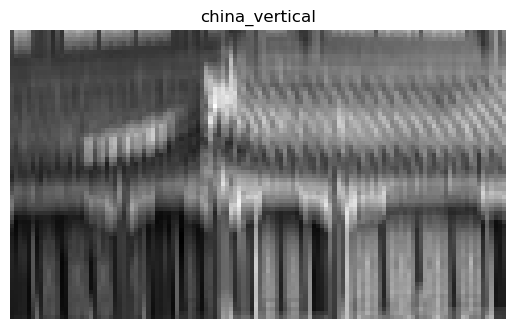

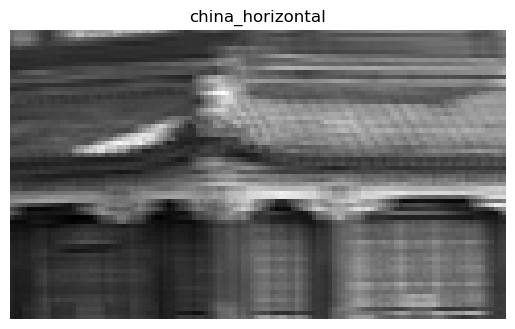

In [16]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    plt.title(filename)
    plt.show()

6. 观察滤波器

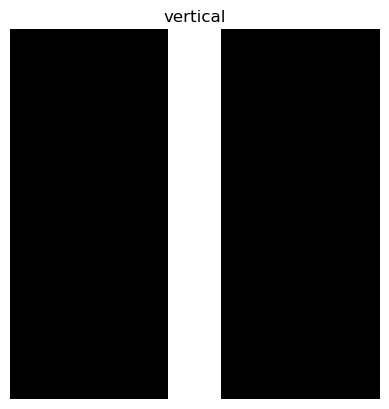

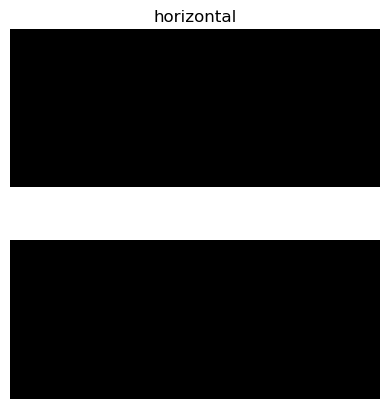

In [17]:
plot_image(filters[:, :, :, 0])
plt.title("vertical")
plt.show()
plot_image(filters[:, :, :, 1])
plt.title("horizontal")
plt.show()

## Conv2D

以上的实例,我们手动定义了滤波器,但是在实际的`CNN`中,通常将滤波器定义为可训练的变量,卷积层在训练时会在学习适当的过滤器和偏置的参数.

- 使用`keras.layers.Conv2D`层

In [18]:
initialization()

conv = keras.layers.Conv2D(
    filters=2,  # 滤波器数量
    kernel_size=7,  # 滤波器宽高
    strides=1,
    padding="SAME",
    activation=keras.activations.relu,
)

后续可以使用交叉验证来找到正确的超参数的值.

In [19]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

- 绘制特征图

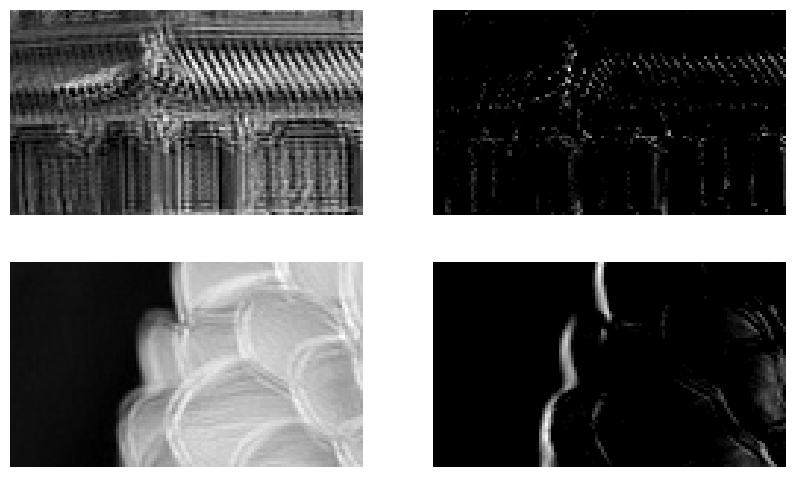

In [20]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

尽管过滤器是随机初始化的，但第二个过滤器恰好充当边缘检测器.

- 手动设置过滤器参数

In [21]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 中间有垂直白线
filters[3, :, :, 1] = 1  # 中间有水平白线

In [22]:
conv.set_weights([filters, np.zeros(2)])  # 偏置设置为0

In [23]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

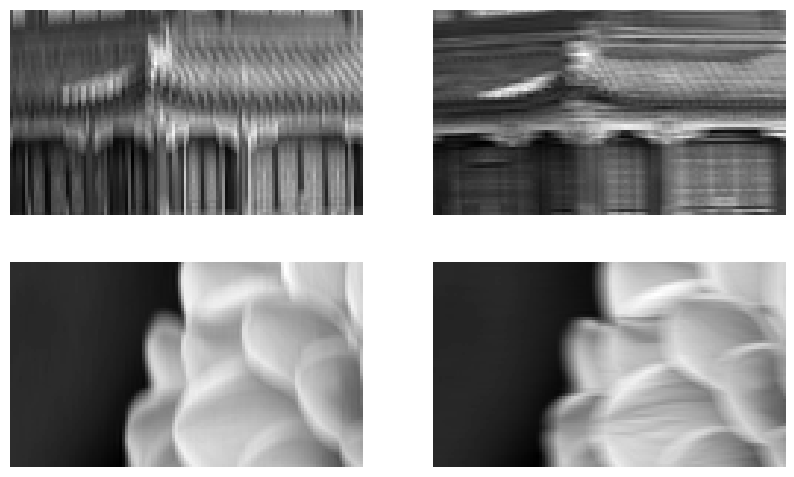

In [24]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## `SAME` 与 `VALID`

> 假设卷积层的输入神经元个数为$M$,卷积大小为$K$,步长为$S$,在输入两端各填补$P$个0,那么该卷积层的输出长度为$\frac{M-K+2P}{S}+1$.

`padding`必须为`SAME`或`VALID`,
- 如果设置为`SAME`,则卷积层在必要时使用**零填充**。将输出大小设置为**输入神经元的数量除以步幅(向上取整)所得的值**。例如,如果输入大小为13而步幅为5,则输出大小为3,然后根据需要在输入周围尽可能均匀地添加零。**当 `strides=1`时,层的输出将具有与其输入相同的空间尺寸(宽度和高度)**,因此命名为`SAME`.
     - `等宽卷积`:步长$S=1$,两端补零$P=\frac{K-1}{2}$,卷积输出长度为$M$
- 如果设置为`VALID`,则卷积层将**不使用零填充**,并且可能会忽路输入图像底部和右侧的某些行和列,具体取决于步幅,这意味着每个神经元的接受野都严格位于输入内部的有效位置内(不会超出范围),因此命名为`VALID`.
    - `窄卷积`:步长$S=1$,$P=0$,卷积输出长度为$M-K+1$

In [25]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1  # SAME
    else:
        return (input_size - kernel_size) // strides + 1  # VALID

In [26]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [27]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [28]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1,
                                 kernel_size=kernel_size,
                                 strides=strides,
                                 padding="VALID")
conv_same = keras.layers.Conv2D(filters=1,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# 需要调用 build() 以便创建 conv_same 的权重
conv_same.build(tf.TensorShape(images.shape))

# 将权重从 conv_valid 复制到 conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

# np.allclose: 比较两个array是不是每一元素都相等
assert np.allclose(valid_output.numpy(), same_output.numpy())

使用 `SAME` 填充相当于使用 `manual_same_padding()`,然后使用 `VALID` 填充.

## 特征图的行列数计算

对于 $n × n$ 的矩阵, 使用 $f×f$ 的核进行卷积, 填充宽度为 $p$, 若纵向步幅为 $s _1$, 横向步幅为 $s_2$则特征图的行列数为:
$$
\left[\frac{n+2p-f}{s_1}+1\right] \times\left[\frac{n+2 p-f}{s_2}+1\right]
$$

In [29]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.],
                 [7., 8., 9.]
                ]) 
# x.shape : TensorShape([3, 3])

x = tf.reshape(x, [1,3,3,1])  # (batch_size, height, width, channels)

In [30]:
x

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]], dtype=float32)>

In [31]:
conv = keras.layers.Conv2D(
    filters=1,  # 滤波器数量
    kernel_size=2,  # 滤波器宽高
    strides=1,
    padding="VALID",
    activation=keras.activations.relu,
)

In [32]:
conv(x).shape  # n(3,3) +2* p(0,0) - f(2,2) / s(1,1) +(1,1)  ==> (2,2)

TensorShape([1, 2, 2, 1])

# 池化层 Pooling layer

`池化层`的目标是对输入图像进行下采样,以便减少计算量,内存使用量和参数数量(从而降低过拟合的风险).

此外,还为引入了一定程度的`小变换不变性`,这在分类任务这样的不依赖于这些细节的预测会很有用.

<img src="../images/other/14-4.png" width="400">

最大池化存在一些缺点:非常具有破坏性;在某些应用中`小变换不变性`不可取,如语义分割.

`Mean Pooling`层曾经非常流行，但现在人们大多使用`Max Pooling`层，因为它们通常表现更好。这似乎令人惊讶，因为计算平均值通常比计算最大值丢失的信息少。但另一方面，`Max Pooling`只保留最强的特征，而将无意义的特征去除，因此下一层得到更清晰的信号来使用。而且，`Max Pooling`提供比`Mean Pooling`更强的平移不变性，并且它需要的计算量略少。

In [33]:
cropped_images = np.array([crop(image) for image in images])

## Max pooling

- 使用`keras.layers.MaxPool2D`层

    使用2×2的内核创建一个最大池化层:步幅默认为内核大小,默认使用`VALID`填充.

In [34]:
max_pool = keras.layers.MaxPooling2D(pool_size=2)

In [35]:
output_Max_pool = max_pool(cropped_images)

In [36]:
def plot_input_output(inputImages, outputImages, ratios=[1,1]):
    fig = plt.figure(figsize=(12, 8))
    # GridSpec:用于指定放置子图的网格的几何形状
    # 参数width_ratios:相对宽度比例 width_ratios[i] / Σwidth_ratios
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=ratios)

    # 绘制输入图像
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Input")
    ax1.imshow(inputImages)  
    ax1.axis("off")

    # 绘制输出图像
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Output")
    ax2.imshow(outputImages, cmap="gray", interpolation="nearest")  
    ax2.axis("off")     

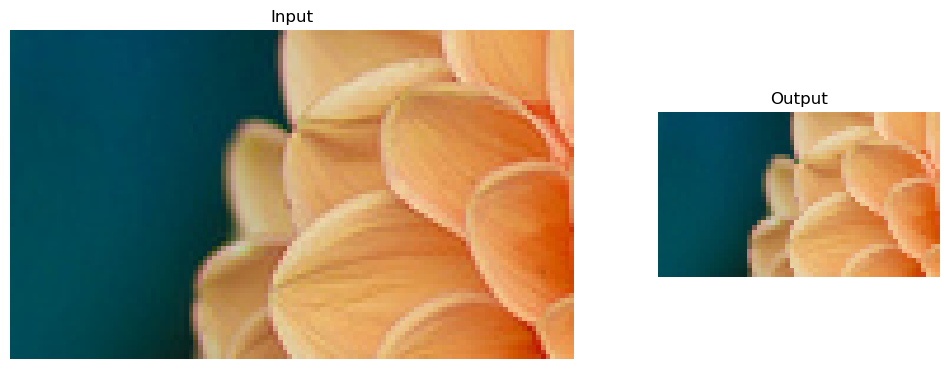

In [37]:
plot_input_output(cropped_images[1], output_Max_pool[1], [2,1])
plt.show()

## Depth-wise pooling

`Depth-wise pooling`可以让`CNN`学习到多种不变性.
<img src="../images/other/14-5.png" width="300">
`Keras`中没有`Depth-wise pooling`,可以使用TF中的低级API:`tf.nn.max_pool`.

>`tf.nn`，`tf.layers`， `tf.contrib`模块有很多功能是重复的.下面是对三个模块的简述：
- `tf.nn` ：提供神经网络相关操作的支持，包括卷积操作（conv）、池化操作（pooling）、归一化、loss、分类操作、embedding、RNN、Evaluation。
- `tf.layers`：主要提供的高层的神经网络，主要和卷积相关的，tf.nn会更底层一些。
- `tf.contrib`：`tf.contrib.layers`提供够将计算图中的 网络层、正则化、摘要操作、是构建计算图的高级操作，但是`tf.contrib`包含不稳定和实验代码，有可能以后API会改变。


方法1:创建一个自定义的`Keras`层

In [38]:
class DeptMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(input=images,
                              ksize=(1,1,1,self.pool_size),
                              # 依次为沿批次,高度,宽度,深度的步长/核大小
                              # 深度的步长/核大小必须可以整除输入深度
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)  

方法2:使用`Lambda`层

In [39]:
depth_pool = keras.layers.Lambda(lambda X:tf.nn.max_pool(
                                  input=X,
                                  ksize=(1, 1, 1, 3),
                                  strides=(1, 1, 1, 3),
                                  padding="VALID")  
                                )

In [40]:
with tf.device("/cpu:0"):    # 指定模型运行的具体设备
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

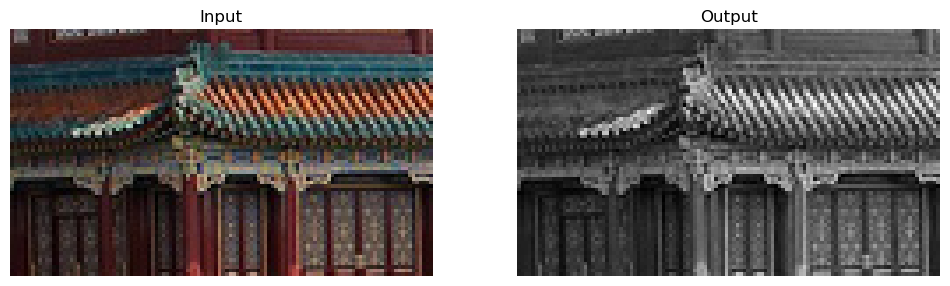

In [41]:
plot_input_output(cropped_images[0], depth_output[0, ..., 0])

## Average pooling

In [42]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_Avg_pool = avg_pool(cropped_images)

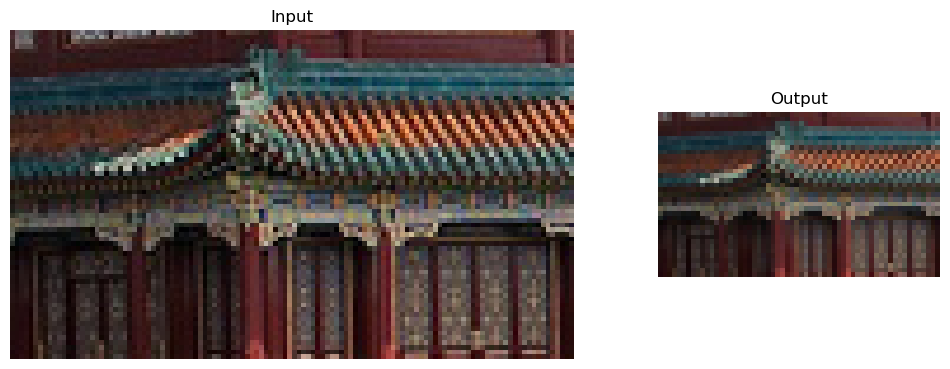

In [43]:
plot_input_output(cropped_images[0], output_Avg_pool[0], [2,1])

## Global Average Pooling

`Global Average Pooling`是将每一张特征图计算所有像素点的均值，输出一个数据值.被认为是可以替代全连接层的一种新技术，将这些特征点组成最后的特征向量，进行`softmax`中进行计算.

In [44]:
global_avg_pool_1 = keras.layers.GlobalAvgPool2D()
global_avg_pool_1(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

等价于以下`Lambda`层:计算空间维度（高度和宽度）的平均值.

In [45]:
output_global_avg_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg_2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

> create:Apotosome 01/24/22

> update:Apotosome 10/26/22